In [4]:
#using hive on pyspark.

#installing pyspark
!pip install pyspark
!pip install matplotlib



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=0c92c95ced3372a007e901b8d6f15a2f6bf972f23e1a90dbf5a85becd54a8731
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [5]:
#Initialize a Spark Session:

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Colab") \
    .config("spark.sql.warehouse.dir", "/content/spark-warehouse") \
    .enableHiveSupport() \
    .getOrCreate()


In [6]:
#set up Hadoop Configuration

import os

# Setting Hadoop home directory and appending to system path
os.environ["HADOOP_HOME"] = "/usr/local/hadoop"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["HADOOP_HOME"], "bin")


In [7]:
# reading csv file.

# Path to your CSV file
csv_file_path = '/content/drive/MyDrive/6110/BostonHousing-1.csv'

# Load the CSV file into a DataFrame
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Show the DataFrame to verify
df.show()


+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
|0.02985| 0.0| 2.18|   0|0.458| 6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|
|0.08829|12.5| 7.87|   0|0.524|6.012| 66.6|5.5605|  5|311|   15.2| 395.6|12.43|22.9|
|0.14455|12.5| 7.87|   0|0.524|6.172| 96.1|5.9505|  5|311|   15.2| 396.9|19.15|27.1|
|0.21124|12.5| 7.87|   0|0.524|5.631|100.0|6.0821|  5|311|   15.2

In [8]:
# Combine features to a single vector columns using VectorAssembler (all columns other than target column 'medv')

from pyspark.ml.feature import VectorAssembler

# Define the input columns
input_cols = df.columns[:-1]

# Define the output column
output_col = "mdev"

# Create a VectorAssembler instance
vec_assembler = VectorAssembler(inputCols=input_cols, outputCol=output_col)

# Transform the DataFrame
df_transformed = vec_assembler.transform(df)

# Show the DataFrame with the new features column
df_transformed.select(output_col).show(truncate=False)


+----------------------------------------------------------------------------+
|mdev                                                                        |
+----------------------------------------------------------------------------+
|[0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98]     |
|[0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14]    |
|[0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03]   |
|[0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94]   |
|[0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33]    |
|[0.02985,0.0,2.18,0.0,0.458,6.43,58.7,6.0622,3.0,222.0,18.7,394.12,5.21]    |
|[0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.6,12.43]  |
|[0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.9,19.15]  |
|[0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93]|
|[0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,

In [9]:
# Standardize features for principal component analysis

from pyspark.ml.feature import StandardScaler

# Define the input column
input_col = "mdev"

# Define the output column
output_col = "scaled_features"

# Create a StandardScaler instance
scaler = StandardScaler(inputCol=input_col, outputCol=output_col)

# Fit the scaler to the data
scalerModel = scaler.fit(df_transformed)

# Transform the data
scaled_data = scalerModel.transform(df_transformed)

# Show the DataFrame with the standardized features
scaled_data.select(output_col).show(truncate=False)


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                                                         |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[7.347517129314295E-4,0.7717884565672898,0.33671737006839275,0.0,4.64282698889716,9.357870159614736,2.3162570967793923,1.9423376220117814,0.1148466992737183,1.7562896940960828,7.067152421345664,4.347451553571431,0.6973753120717119] |
|[0.003175010962050212,0.0,1.0305592235426566,0.0,4.04737148

In [10]:
# train model for two principal component analysis

from pyspark.ml.feature import PCA

# Define the input column
input_col = "scaled_features"

# Define the output column
output_col = "pca_features"

# Create a PCA instance with 2 principal components
pca = PCA(k=2, inputCol=input_col, outputCol=output_col)

# Fit the model to the data
model = pca.fit(scaled_data)

# Transform the data
transformed_data = model.transform(scaled_data)

# Show the DataFrame with the principal components
transformed_data.select(output_col).show(truncate=False)


+------------------------------------------+
|pca_features                              |
+------------------------------------------+
|[-1.2551263234672798,0.619208753048265]   |
|[-1.8955383642584411,0.43826027853267524] |
|[-1.2788028017576778,0.4459069048066415]  |
|[-0.7424275948415135,-0.16000349959138044]|
|[-0.8955945817747853,-0.05552432724763588]|
|[-1.1386875105130903,-0.1626173058875903] |
|[-1.9938116978405127,0.19638661842032645] |
|[-2.5101372119925514,0.42408881980581625] |
|[-3.1715989580575763,0.18903985467514833] |
|[-2.2782272156701686,0.1627491476656405]  |
|[-2.442836900985915,0.35411004177272076]  |
|[-2.1089238064836033,0.25955123545832715] |
|[-1.8898983043794966,-0.16514637273853727]|
|[-2.616302407976548,-0.2803088076568197]  |
|[-2.9916877611813377,-0.02198932636098055]|
|[-2.632002162610281,-0.3343045948662986]  |
|[-2.2516610353291657,-0.6331788630832922] |
|[-3.2007853788687837,-0.0754050688535747] |
|[-3.0011290868678695,-0.8373780300742931] |
|[-3.04803

In [11]:
# Collect distributed data in numpy array and then convert to pandas dataframe , and make different column for each feature

import numpy as np
import pandas as pd

# Collect the distributed data into a local NumPy array
np_arr = transformed_data.select(output_col).collect()

# Convert the NumPy array to a Pandas DataFrame
df_pca = pd.DataFrame(np.concatenate(np_arr, axis=0))

# Create different columns for each feature
df_pca.columns = ["pc1", "pc2"]

# Print the DataFrame
print(df_pca.head())


        pc1       pc2
0 -1.255126  0.619209
1 -1.895538  0.438260
2 -1.278803  0.445907
3 -0.742428 -0.160003
4 -0.895595 -0.055524


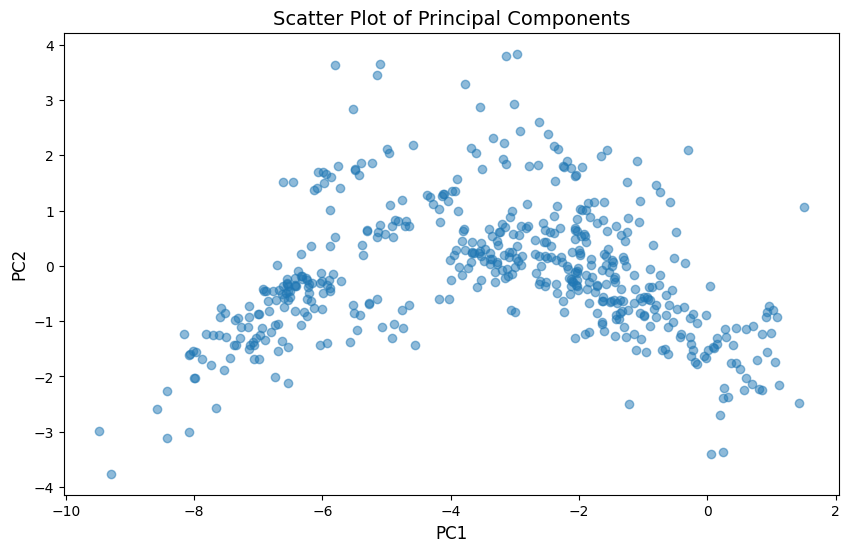

In [12]:
# Plot two principal components

import matplotlib.pyplot as plt

# Extract the principal components
pc1 = df_pca["pc1"].tolist()
pc2 = df_pca["pc2"].tolist()

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pc1, pc2, alpha=0.5)

# Add labels and title
plt.xlabel("PC1", fontsize=12)
plt.ylabel("PC2", fontsize=12)
plt.title("Scatter Plot of Principal Components", fontsize=14)

# Show the plot
plt.show()


In [13]:
# Vectorize features and target together for model development

from pyspark.ml.feature import VectorAssembler

# Define the input columns
input_cols = df.columns[:-1] + ["medv"]

# Define the output column
output_col = "features"

# Create a VectorAssembler instance
vec_assembler = VectorAssembler(inputCols=input_cols, outputCol=output_col)

# Transform the DataFrame
df_transformed = vec_assembler.transform(df)

# Show the DataFrame with the new features column
df_transformed.select(output_col).show(truncate=False)


+---------------------------------------------------------------------------------+
|features                                                                         |
+---------------------------------------------------------------------------------+
|[0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98,24.0]     |
|[0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6]    |
|[0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7]   |
|[0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4]   |
|[0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33,36.2]    |
|[0.02985,0.0,2.18,0.0,0.458,6.43,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7]    |
|[0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.6,12.43,22.9]  |
|[0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.9,19.15,27.1]  |
|[0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93

In [14]:
# Split dataset into training and testing dataset

# Split the data into training and testing sets
(train_data, test_data) = df_transformed.randomSplit([0.8, 0.2])

# Print the number of rows in each set
print("Number of rows in training data:", train_data.count())
print("Number of rows in testing data:", test_data.count())


Number of rows in training data: 403
Number of rows in testing data: 103


In [15]:
# Fit model for linear regression

# Import LinearRegression
from pyspark.ml.regression import LinearRegression

# Define the input and output columns
input_col = "features"
output_col = "medv"

# Instantiate the LinearRegression model
lr = LinearRegression(featuresCol=input_col, labelCol=output_col)

# Fit the model to the training data
model = lr.fit(train_data)

# Print the model summary
print("Coefficients:", model.coefficients)
print("Coefficients:", model.summary)


Coefficients: [2.5939696682381046e-16,7.841778383346358e-16,-1.0750077261743476e-15,1.3895469322762786e-14,-1.328803254032185e-14,-4.1384513534822095e-14,-1.717146454999876e-16,-1.2704677836331162e-14,-3.033784259080253e-16,-9.350759141739746e-17,1.754384443305311e-14,-6.326957461333006e-17,-2.9546538598961687e-16,1.0000000000000033]
Coefficients: <pyspark.ml.regression.LinearRegressionTrainingSummary object at 0x7d2f4932f2e0>


In [16]:
# Find out model coefficients and intercept

# Extract the model coefficients and intercept
coefficients = model.coefficients
intercept = model.intercept

# Print the coefficients and intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)


Coefficients: [2.5939696682381046e-16,7.841778383346358e-16,-1.0750077261743476e-15,1.3895469322762786e-14,-1.328803254032185e-14,-4.1384513534822095e-14,-1.717146454999876e-16,-1.2704677836331162e-14,-3.033784259080253e-16,-9.350759141739746e-17,1.754384443305311e-14,-6.326957461333006e-17,-2.9546538598961687e-16,1.0000000000000033]
Intercept: 0.0


In [17]:
# Evaluate model for test dataset

import numpy as np
# Make predictions on the test data
predictions = model.transform(test_data)

# Select the predicted and actual values
predicted_values = predictions.select("prediction").collect()
actual_values = predictions.select("medv").collect()

# Calculate the mean squared error
mse = np.mean((np.array(predicted_values) - np.array(actual_values))**2)

# Print the mean squared error
print("Mean squared error:", mse)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

# Print the root mean squared error
print("Root mean squared error:", rmse)


Mean squared error: 1.6087631041202834e-27
Root mean squared error: 4.0109389226467705e-14


In [18]:
#  further analysis for better interpretation of model results.

import matplotlib.pyplot as plt
# Calculate the R-squared value
r2 = model.summary.r2

# Print the R-squared value
print("R-squared:", r2)

# Calculate the adjusted R-squared value
adjusted_r2 = model.summary.r2adj

# Print the adjusted R-squared value
print("Adjusted R-squared:", adjusted_r2)

# Calculate the mean absolute error
mae = model.summary.meanAbsoluteError

# Print the mean absolute error
print("Mean absolute error:", mae)





R-squared: 1.0
Adjusted R-squared: 1.0
Mean absolute error: 2.915120584956217e-14
